In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from utils.elfnn import ELFNN

### Load and analyze data

In [2]:
elf = ELFNN()
elf.load_data(sort=True, structure=True, drop_duplicates=True)

Drop duplicates: 100%|██████████| 2400/2400 [00:00<00:00, 58926.01it/s]         


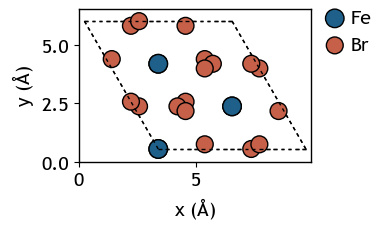

In [3]:
elf.plot_structure(elf.bm.iloc[0].structure);

In [4]:
elf.get_distances(column='elf')    # compute distances from unlabeled examples to most similar labeled example

Compute EMD: 100%|██████████| 33086/33086 [00:02<00:00, 14105.68it/s]           


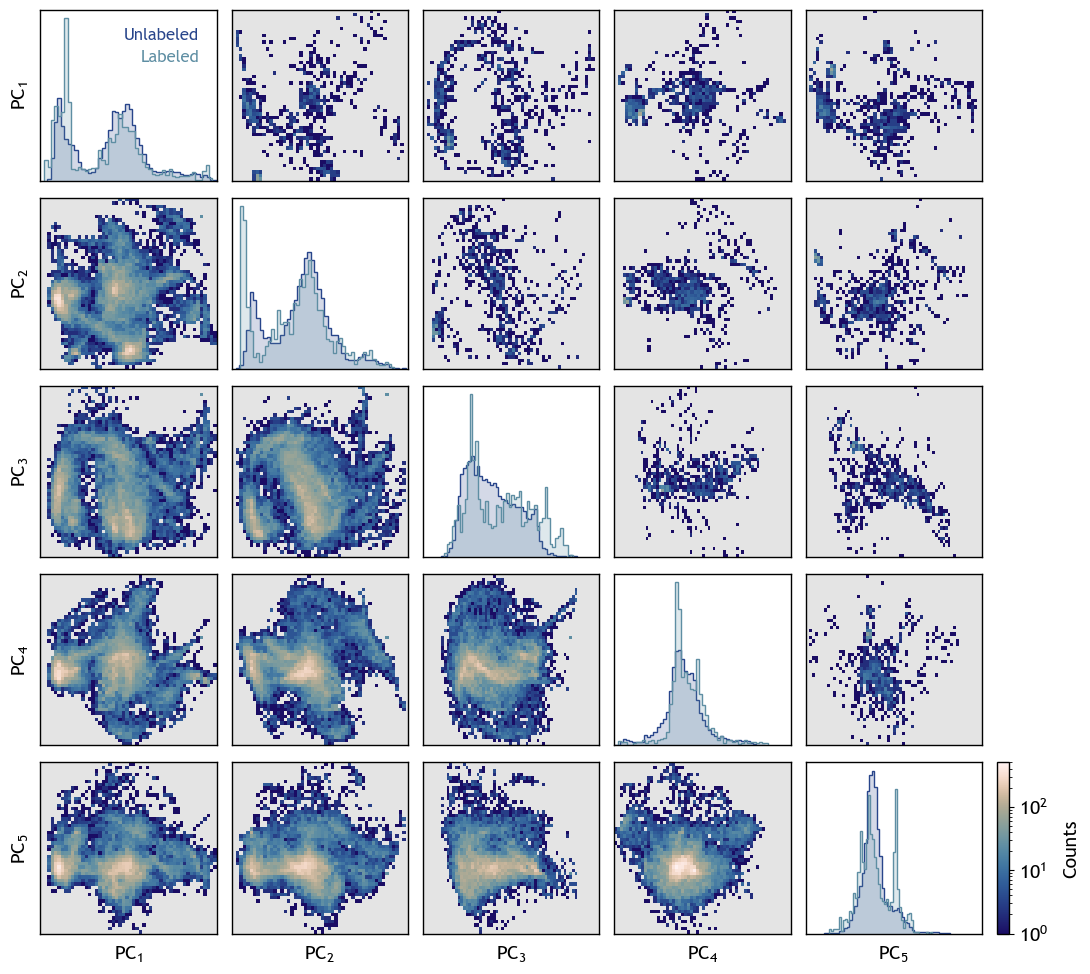

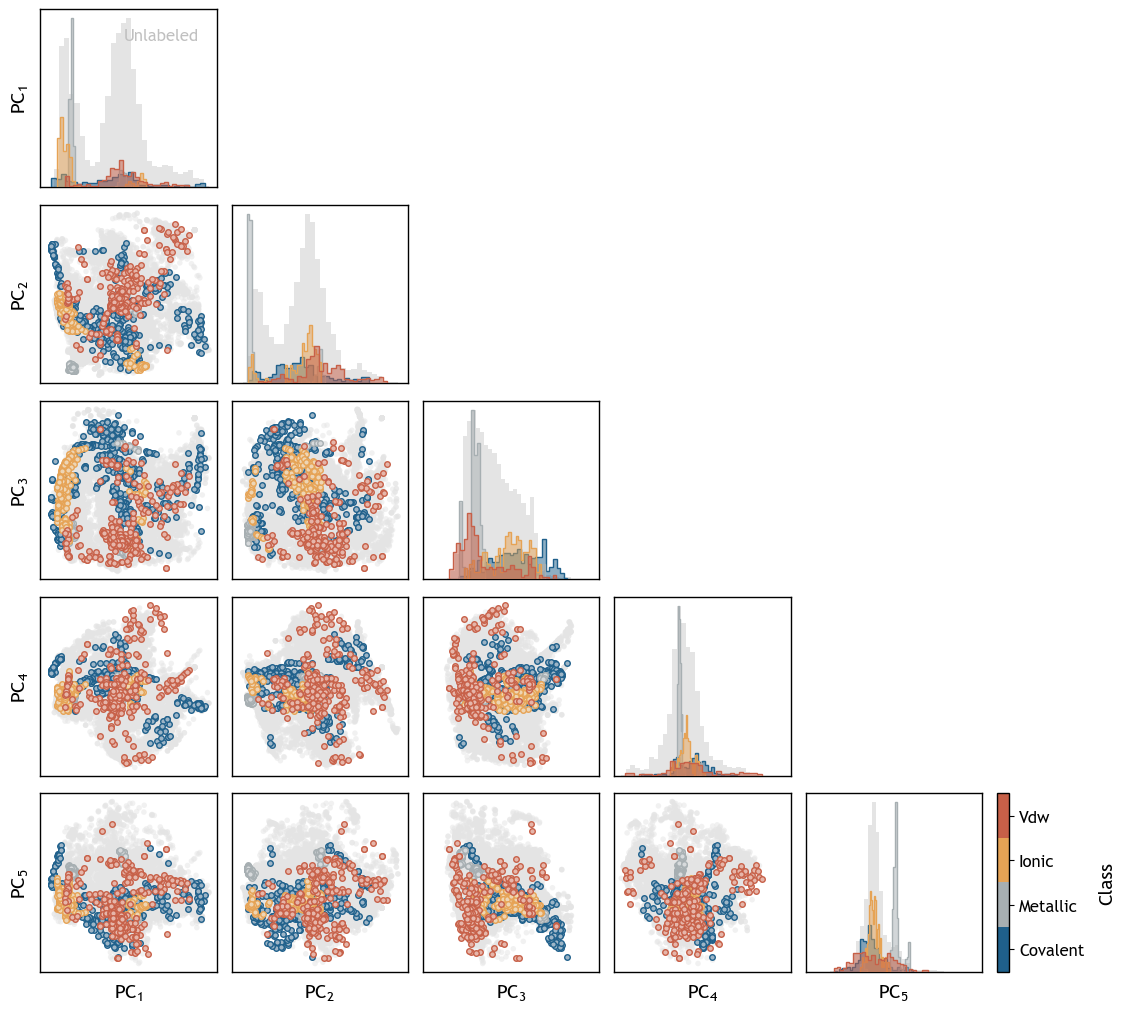

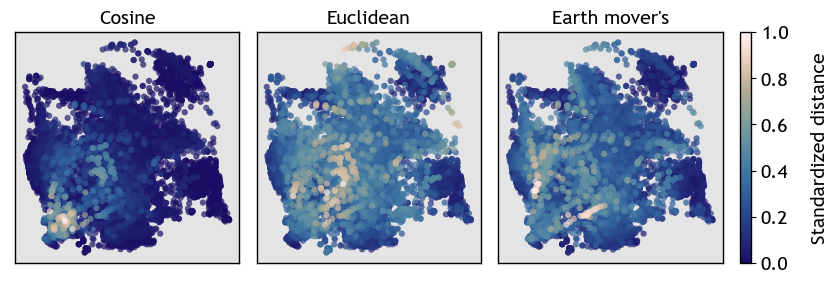

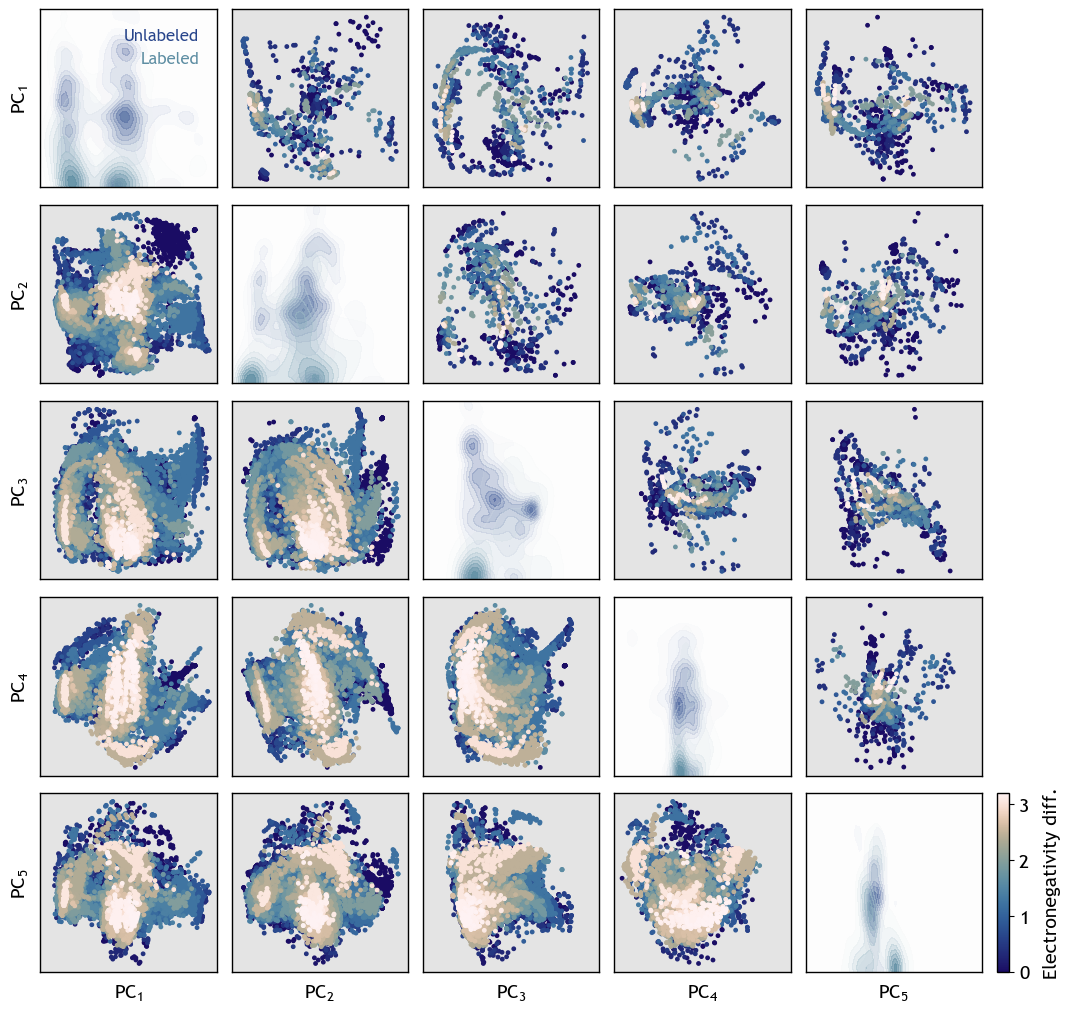

In [5]:
elf.pca_fit(ev=0.9995)                       # perform PCA on the ELF profiles
elf.plot_pca_distribution(orig=True)         # visualize distribution of examples in principal component space
elf.plot_pca_labels(orig=True)               # visualize distribution of labels in principal component space
elf.plot_pca_distances(orig=True)            # plot distance to most similar labeled example
elf.plot_pca_features('e_diff', orig=True);  # visualize distribution of features in principal component space

### Process data and train networks

In [6]:
# transform data
elf.pca_fit(ev=0.9995)                         # reduce dimensionality of ELF profiles
elf.prepare_inputs(inputs=['z', 'e_diff'])     # define input columns
elf.scaler_fit()                               # standardize input columns

In [7]:
# train/test split
test_size = 0.2
elf.stratified_split(test_size)                # train/test split

n_splits = 100
elf.kfold_split(n_splits, test_size)           # ensemble split

In [ ]:
# define and train models
model_path = 'models/stc_120522_srt_pca_en'
elf.init_clf(alpha=0.01, hidden_layer_sizes=(10,),
             activation='relu', max_iter=1000, batch_size=32)           # define classifier hyperparameters
elf.self_train_clf(threshold=0.4, max_iter=50, model_path=model_path)   # self-train classifier

In [ ]:
# evaluate trained models

### Predict using trained networks

In [8]:
# load trained network
elf = ELFNN()
elf.load_model(model_path)

In [9]:
# load target examples (just loading the labeled and unlabeled training data for now)
elf.load_data(sort=True, structure=True, drop_duplicates=True)
data = elf.data.copy()

In [10]:
# transform target data
data = elf.pca_transform(data)
data = elf.prepare_inputs(inputs=['z', 'e_diff'], data=data)
data = elf.scaler_transform(data)    

In [13]:
# predict on target data
data = elf.predict(data, threshold=0) 

Threshold: 0.4


In [14]:
data.head()

,r_src,r_dst,e_src,e_dst,g_src,g_dst,e_diff,edge_src,edge_dst,l,...,d_emd,z,z_orig,input,input_scaled,y_pred_mean,y_pred_std,y_class,y_class_mean,y_class_std
0,1.25,1.40,2.01,2.10,14,16,0.09,0,1,3.065632,...,0.773180,"[-0.21558673260667555, 0.28335616935550695, 0....","[-0.4953967065290124, 0.4087140704169187, 0.58...","[-0.21558673260667555, 0.28335616935550695, 0....","[-0.22725862795141927, 0.41906093917987414, 0....","[0.715864498003002, 0.020654332195022964, 7.27...","[0.3920102876302254, 0.13623829336242804, 5.88...",0,0.715864,3.920103e-01
1,1.25,1.40,2.01,2.10,14,16,0.09,0,3,3.065632,...,0.606056,"[-0.35095996279711666, 0.5401831172537781, 0.2...","[-0.5181293073197591, 0.1708578801805283, 0.77...","[-0.35095996279711666, 0.5401831172537781, 0.2...","[-0.36996098343708633, 0.7988872977791789, 0.4...","[3.186969114453536e-05, 0.3500449659458025, 2....","[0.00019055838767643017, 0.4113186082644467, 1...",3,0.649921,4.112966e-01
2,1.40,1.25,2.10,2.01,16,14,0.09,1,0,3.065632,...,0.773180,"[-0.21558673260667613, 0.2833561693555073, 0.3...","[0.8145388450367531, -0.5423912417803283, -0.0...","[-0.21558673260667613, 0.2833561693555073, 0.3...","[-0.22725862795141988, 0.41906093917987464, 0....","[0.715864498003006, 0.020654332195022974, 7.27...","[0.39201028763022305, 0.13623829336242818, 5.8...",0,0.715864,3.920103e-01
3,1.40,1.80,2.10,2.33,16,14,0.23,2,5,3.189812,...,0.776037,"[-0.3211984675732579, -0.12311283773406156, 0....","[0.9446835237900303, -0.7498426321591072, -0.4...","[-0.3211984675732579, -0.12311283773406156, 0....","[-0.3385881967698449, -0.18207396550878255, 0....","[0.9999999547112204, 3.3668922930568194e-08, 3...","[3.411671129446795e-07, 3.348532985244373e-07,...",0,1.000000,3.411671e-07
4,1.40,1.80,2.10,2.33,16,14,0.23,2,7,3.189812,...,0.602972,"[-0.48253851957203736, 0.12766709469243565, 0....","[0.8846791151181533, -0.9060485557371856, -0.3...","[-0.48253851957203736, 0.12766709469243565, 0....","[-0.50866322136678, 0.18880934452870501, 0.836...","[0.8706272056501855, 0.008924970060567196, 7.1...","[0.2825283292159414, 0.08876945249869948, 4.44...",0,0.870627,2.825283e-01
